In [1]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import os
import pickle

%matplotlib inline

In [2]:
with open('camera_parameters.p', 'rb') as pfile:
    camera_parameters = pickle.load(pfile)
    
cameraMatrix, distCoeffs = camera_parameters['cameraMatrix'], camera_parameters['distCoeffs']

def lane_filtering(img, cameraMatrix, distCoeffs,
                  threshold_x=(10, 100), 
                  threshold_y=(20, 200), 
                  threshold_angle=(0.6, 1.5), 
                  threshold_mag=(40, 200),
                  threshold_s=(170, 255),
                  threshold_r=(230, 255)):
    img = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    channel_r = img[...,0]
    channel_s = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[...,2]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=7)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=7)
    grad_angle = np.arctan2(grad_y, grad_x)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_x = np.uint8(255 * grad_x / grad_x.max())
    grad_y = np.uint8(255 * grad_y / grad_y.max())
    grad_mag = np.uint8(255 * grad_mag / grad_mag.max())
    
    (mask_x, mask_y, mask_angle, mask_angle1, mask_angle2, 
     mask_mag, mask_r, mask_s, mask_combined) = np.tile(np.zeros_like(grad_x), (9, 1, 1))
    mask_x[(grad_x>threshold_x[0])&(grad_x<threshold_x[1])] = 1
    mask_y[(grad_y>threshold_y[0])&(grad_y<threshold_y[1])] = 1
    mask_mag[(grad_mag>threshold_mag[0])&(grad_mag<threshold_mag[1])] = 1
    
    mask_angle1[(grad_angle>threshold_angle[0])&(grad_angle<threshold_angle[1])] = 1
    mask_angle2[(grad_angle>-threshold_angle[1])&(grad_angle<-threshold_angle[0])] = 1
    mask_angle[(mask_angle1 == 1) | (mask_angle2 == 1)] = 1
    
    mask_r[(channel_r>threshold_r[0])&(channel_r<threshold_r[1])] = 1
    mask_s[(channel_s>threshold_s[0])&(channel_s<threshold_s[1])] = 1
    
    
    mask_combined[((mask_r == 1) | (mask_s == 1)) | ( (mask_x == 1))] = 1 
    masks = (mask_x, mask_y, mask_angle, mask_mag, mask_s, mask_r)
    img_channels = (grad_x, grad_y, grad_angle, grad_mag, channel_s, channel_r)
    
    return mask_combined, masks, img_channels

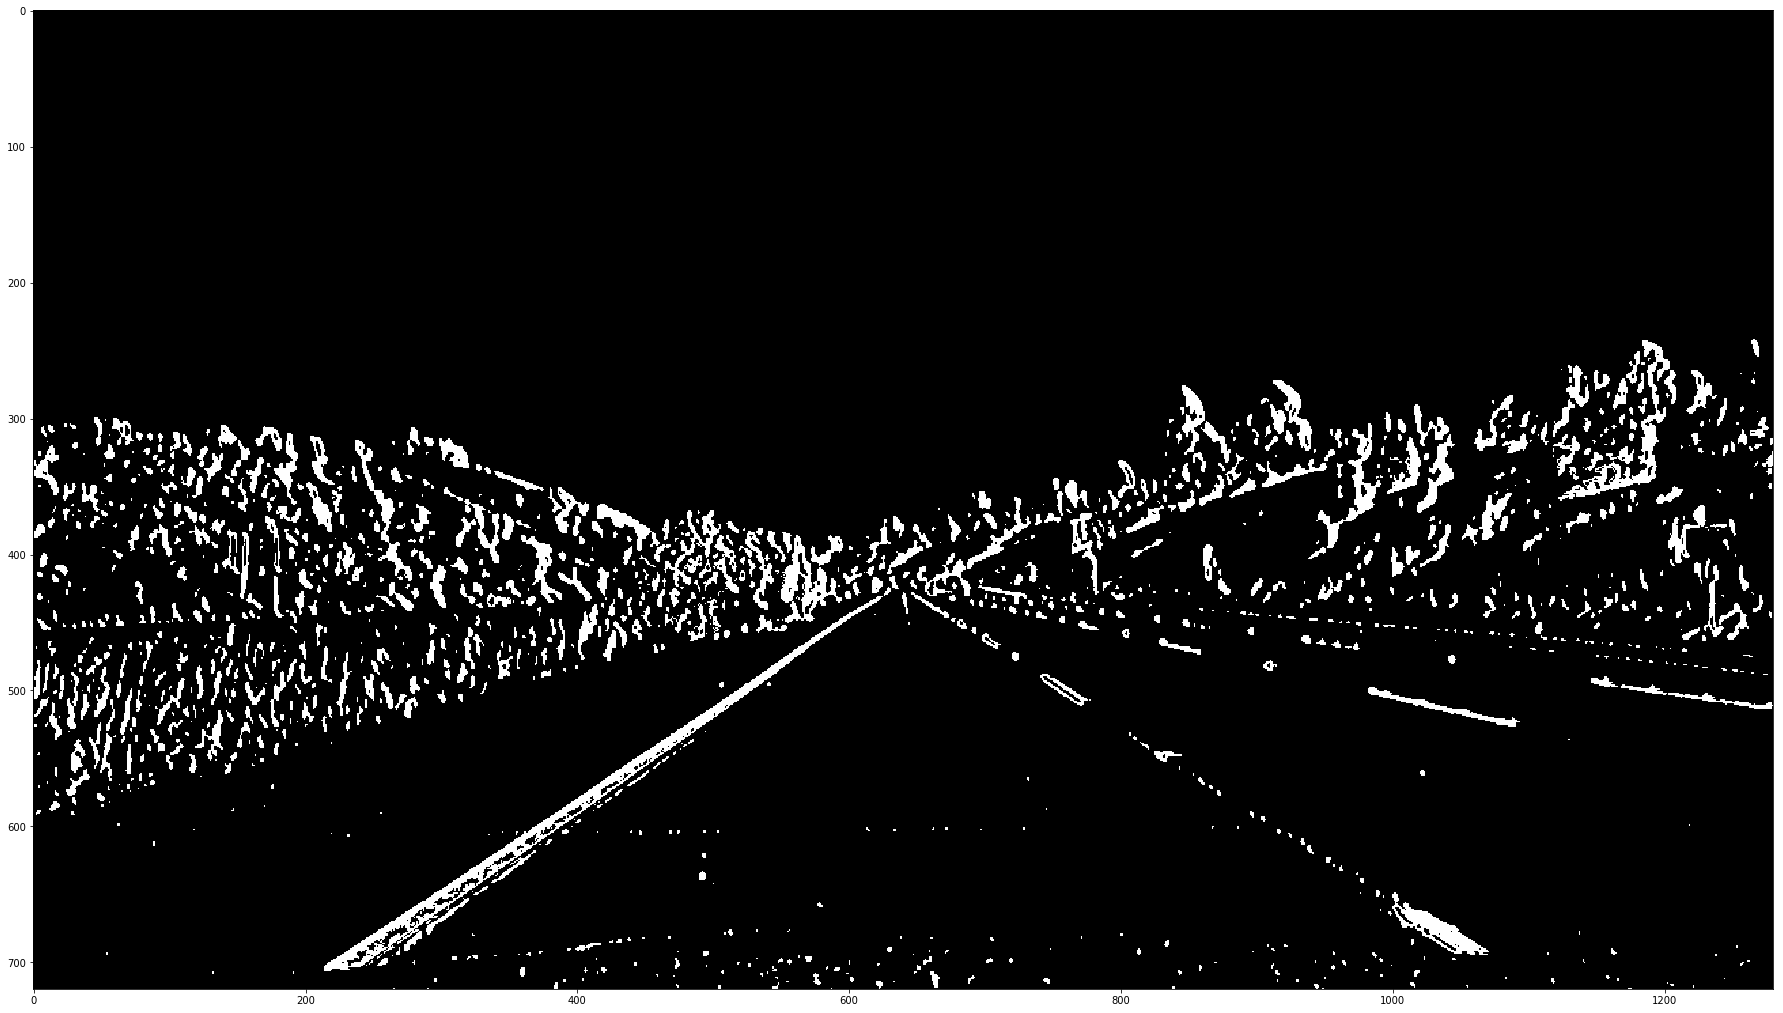

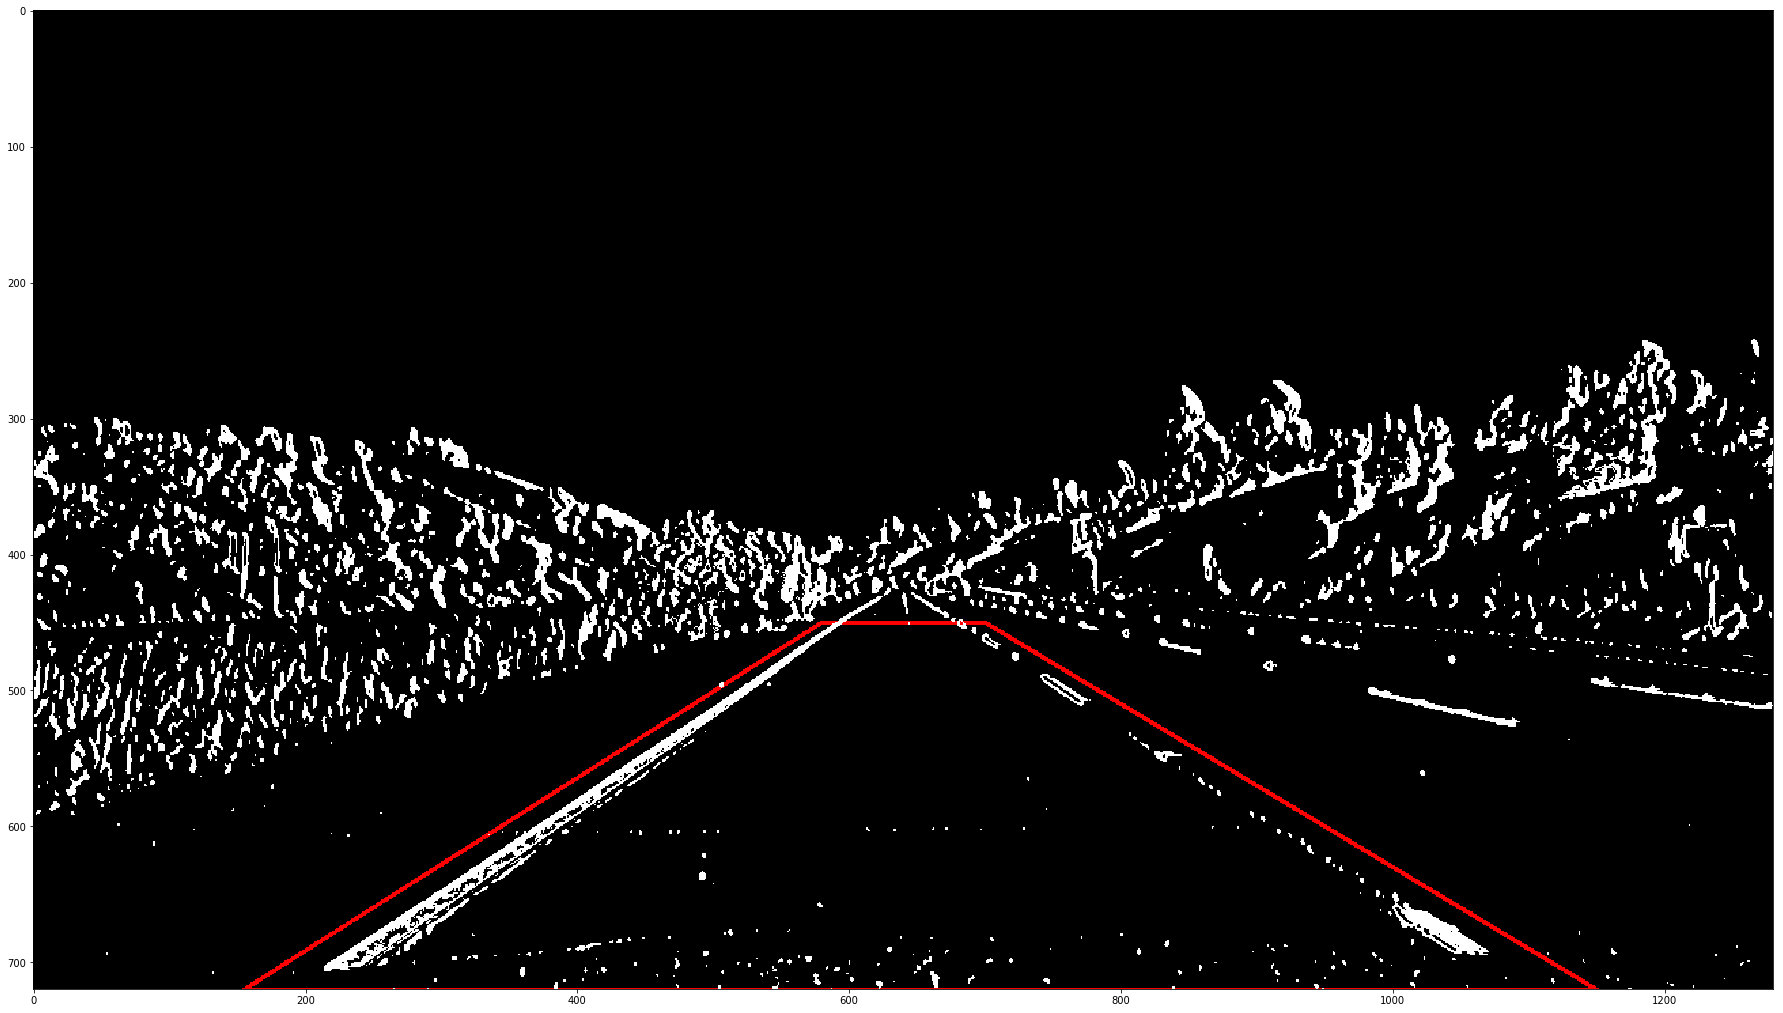

In [3]:
img = cv2.imread('test_images/straight_lines1.jpg')
mask_combined, masks, img_channels = lane_filtering(img, cameraMatrix, distCoeffs)
mask_x, mask_y, mask_angle, mask_mag, mask_s, mask_r = masks
grad_x, grad_y, grad_angle, grad_mag, channel_s, channel_r = img_channels

plt.figure(figsize=(32, 18))
plt.imshow(mask_combined, 'gray')
plt.show()

trapezoid = np.zeros_like(img)
src_pts = np.array([[155, 720], [580, 450], [700, 450], [1150, 720]])
pts2 = np.array([[130, 720], [575, 400], [800, 400], [1150, 720]])
cv2.polylines(trapezoid, [src_pts], True, (255, 0, 0), 2)
mask_combined2 = np.tile(mask_combined, (3, 1, 1)).transpose((1, 2, 0))
mask_combined2 = mask_combined2 * 255
plt.figure(figsize=(32, 18))
img_add = cv2.addWeighted(mask_combined2, 1, trapezoid, 1, 0)
plt.imshow(img_add)
plt.show()

In [4]:
camera_parameters

{'cameraMatrix': array([[1.15158804e+03, 0.00000000e+00, 6.66167057e+02],
        [0.00000000e+00, 1.14506859e+03, 3.86440204e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'distCoeffs': array([[-2.35510339e-01, -7.90388401e-02, -1.28492203e-03,
          8.25970403e-05,  7.22743173e-02]])}